# Initialize Environment

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import os

In [2]:
%matplotlib inline
%load_ext tensorboard.notebook

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Image at 18435


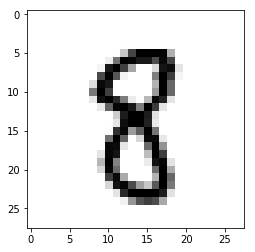

In [4]:
sample_pos = random.randint(1, x_train.shape[0])
print(f"Image at {sample_pos}")
plt.imshow(x_train[sample_pos - 1], cmap = plt.cm.binary)

# Normalize Data

Done using a BatchNormalization layer

# Define Model

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(28*28, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Train Model

In [6]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [8]:
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
model.fit(x=x_train,
          y=y_train,
          epochs = 5,
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 277us/sample - loss: 0.2311 - accuracy: 0.9293 - val_loss: 0.1083 - val_accuracy: 0.9680
Epoch 2/5
60000/60000 [==============================] - 16s 267us/sample - loss: 0.1153 - accuracy: 0.9647 - val_loss: 0.1036 - val_accuracy: 0.9687
Epoch 3/5
60000/60000 [==============================] - 16s 266us/sample - loss: 0.0908 - accuracy: 0.9720 - val_loss: 0.0860 - val_accuracy: 0.9743
Epoch 4/5
60000/60000 [==============================] - 16s 274us/sample - loss: 0.0733 - accuracy: 0.9772 - val_loss: 0.0748 - val_accuracy: 0.9776
Epoch 5/5
60000/60000 [==============================] - 16s 267us/sample - loss: 0.0589 - accuracy: 0.9815 - val_loss: 0.0735 - val_accuracy: 0.9804


# Verify Model

In [10]:
val_loss, val_acc = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 90us/sample - loss: 0.0735 - accuracy: 0.9804


In [12]:
%tensorboard --logdir './logs/fit'

Reusing TensorBoard on port 6006 (pid 6516), started 0:02:03 ago. (Use '!kill 6516' to kill it.)

# Use Model

In [13]:
predictions = model.predict([x_test])

In [14]:
print(np.argmax(predictions[0]))

7


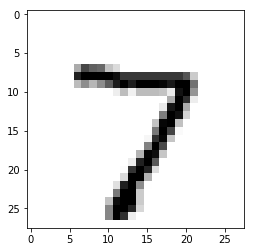

In [15]:
plt.imshow(x_test[0], cmap = plt.cm.binary)

# Save Model

In [16]:
model.save('tf_mnist_dnn.model')